<a href="https://colab.research.google.com/github/hillsonghimire/EO-training-resources/blob/main/Topographic_Wetness_Index_(TWI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
#  Title:  Topographic Wetness Index in Google Earth Engine (python api)
#  Author: hillson ghimire
#  Date:   7 Feb 2024
# ==========================================

**The topographic wetness index (TWI)**, also known as the compound topographic index (CTI), is a **steady state wetness index**. It is commonly used to quantify topographic control on hydrological processes. The index is a function of both the **slope** and the **upstream contributing area per unit width orthogonal to the flow direction**. The index was designed for hillslope catenas. Accumulation numbers in flat areas will be very large, so TWI will not be a relevant variable. The index is highly correlated with several soil attributes such as horizon depth, silt percentage, organic matter content, and phosphorus.

Calculation for TWI:

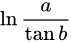

where,

a       = local upslope area draining through a certain point per contour length (sq. meter)

tan *b* = is the local slope in radians

#### **Import necessary libraries**

In [ ]:
# ! pip install geemap >> /dev/null
# ! pip install pycrs >> /dev/null

import ee
import math
import geemap

ee.Authenticate()

In [ ]:
ee.Initialize(project='[Your-Project-ID]')

#### **FAO_GAUL_2015 Country boundaries to select AOI**

In [ ]:
# https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0#table-schema

faoGAUL = ee.FeatureCollection('FAO/GAUL/2015/level0')

# # GAUL Codes : https://data.apps.fao.org/catalog/dataset/gaul-codes
# names = faoGAUL.aggregate_array('ADM0_NAME')
# keys = ee.Dictionary(names).keys()
# display(keys.getInfo())

aoi = faoGAUL.filter(ee.Filter.eq('ADM0_NAME', 'Nepal'))

#### **FLOW ACCUMULATION: Load NASADEM Digital Elevation of 30m resolutions, and HydroSHEDS Flow Accumulation dataset of 15 Arc-Seconds**

In [ ]:
# Select elevation  band from NASADEM
# https://developers.google.com/earth-engine/datasets/catalog/NASA_NASADEM_HGT_001#bands
nasaDEM = ee.Image('NASA/NASADEM_HGT/001')
elev = nasaDEM.select('elevation')

In [ ]:
# Select flow accumulation data from the HydroSheds dataset
hydroSheds = ee.Image("WWF/HydroSHEDS/15ACC")
flowAccumulation = hydroSheds.select('b1')

In [ ]:
# Resample flow accumulation to 30m resolution
flowAccumulation30m = flowAccumulation.resample('bilinear').reproject(crs=elev.projection(), scale=30)

# Compute flow accumulation + 1
accumulation = flowAccumulation30m.add(1)

#### **Determine Slope (in radians)**

In [ ]:
# Compute the slope_deg from the DEM and clip the result to the aoi, convert slope to radians
slope_deg = ee.Terrain.slope(elev).clip(aoi)
slope_tan  = (slope_deg.multiply(math.pi/180)).tan()

#### **Compute TWI**

In [ ]:
# Compute the Topographic Wetness Index (TWI)
TWI = (accumulation.divide(slope_tan)).log()

#### **Visualize**

In [ ]:
Map = geemap.Map(center = [28, 84], zoom = 4)
vis_Para = {'min': -10, 'max': 10, 'palette': ['blue', 'white', 'green']}
Map.addLayer(TWI, vis_Para, name="Rate of Change")
Map

Map(center=[28, 84], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…